# The `SolveAiyagari` notebook <a id="Aiyagari"></a>[<font size=1>(back to `Main.ipynb`)</font>](./Main.ipynb)

This notebook gathers all functions related to the resolution of the Aiyagar model (fiscal policy is exogenous).

## This notebook is organized as follows:
* Computing [policy functions](#pol-fun),
* Computing the [stationary distribution](#stat-dist),
* Characterizing the [steady-state equilibrium](#steady-state).

# Computing policy functions  <a id="pol-fun"></a>[<font size=1>(back to menu)</font>](#Aiyagari)

The EGM algorithm consists of iterating on policy functions up to convergence. Compared to standard VFI or PFI methods, the policy functions of EGM characterize the choices as a function of end-of-period (instead of beginning-of-period) savings. This simplifies the iteration over policy functions and has impact when computing the stationary distribution. Note that in our implementation, we will inverse them in the last stage, when characterizing the [steady-state equilibrium](#steady-state). 

Denoting by  $g_a$ and $g_c$ the policy functions for asset and consumption choices respectively, these functions are defined on the cartesian set of asset choices $\times$ productitivy levels: $[-\underline{a},\infty)\times \mathcal Y$. For any $(a,y)\in[-\underline{a},\infty)\times \mathcal Y$, $g_a(a,y)$ is the beginning-of-period savings 

In practice, the asset choice grid is discretized and is represented by the variable `aGrid::Vector{T}` of the `economy::Economy` variable -- of size`a_size`. The policy functions will be matrices of size `a_size⋅y_size` (where `y_size` is the cardinal of the set of productivity levels $\mathcal Y$). Since policy function are functions of end-of-period savings,  `aGrid[ia]` will represent the end-of-period savings for an agent endowed with beginning-of-period wealth `ga[ia,iy]` and productivity level `ys[iy]`.

The EGM algorithm can be decomposed into the following steps:

1. Start from an initial guess for the post-tax rate $R$ and post-tax wage $w$, and for the asset policy function $g_a$ (seen as a $n_a\times n_y$ matrix here). The policy function is the beginning--of-period savings as a function of end-of-period savings.

2. Compute the  [consumption policy function](#updating-gc) as a function of beginning-of-period savings (and not the opposite for EGM). This key for the next step. 

3. Iterate on the [asset policy function using the Euler equation](#updating-ga). Thanks to the previous step, it is straightfoward to obtain current period consumption as a function of end-of-period savings via the Euler equation. This is where EGM saves time compared to other methods. 

4. Stop if the previous update is minor, otherwise start at step 2 again. If stooped, [return the policy functions](#solve-EGM). 


## Consumption as a function of beginning-of-period savings   <a id="updating-gc"></a>[<font size=1>(back to policy functions)</font>](#pol-fun)

Computing consumption as a function of beginning-of-period savings is done using the individual budget constraint through the following steps:
* We start from a beginning-of-period asset holdings $a = a_{\text{Grid},i_a}$ (given by the asset grid) and a productivity level $y=\mathcal Y_{i_y}$. The indices $(i_a,i_y)$ refer to the *beginning-of-period*. We are interested in consumption associated to $i_a$ (savings $a$)  and $i_y$ (productivity $y$), hence denoted by $c_{i_a,i_y}$.
* We compute using linear interpolation the end-of-period savings, $a^\prime_{i_a,i_y}=lin(a,g_{a,i_y},a_\text{Grid})$, where $lin$ is the interpolration function, $a$ is the beginning-of-period savings, $g_{a,i_y}$ is the vector of beginning-of-period savings in state $i_y$ (do not forget EGM specificity), and $a_\text{Grid}$ is the corresponding vector of end-of-period savings. The linear interpolation function is implemented by `interpLinear` from the [`Utils`](./Utils.ipynb) notebook. 
*  We then compute consumption using the budget constraint: $g_{c,i_a,i_y} =  Ra - a^\prime +w y + T $ -- which exists and is unique. The root is found via `find_zero` of the `Roots`package.


The update is invoked by: 

> `inverse_cEGM!(solution, economy)`, 

where:
* `solution::AiyagariSolution` is a mutable `struct` `AiyagariSolution` which is updated by the function (and hence contains the guess value mentionned above);
* `economy::Economy` is a immutable `struct` `Economy` which contains economy parameters.

The function returns `nothing` but updates `solution` inplace.

> ***Remark.*** The function inverses solely the consumption policy function, which is defined as a function of beginning-of-period savings. Labor and savings policy function are defined as a function of end-of-period savings (as standrad in EGM). This is only temporary and avoids defining a temporary consumption policy function. 


In [1]:
function inverse_c_EGM(solution::AiyagariSolution,
                      economy::Economy)
    
    @unpack Tt,u′,a_size,a_min,aGrid,y_size,ys = economy
    @unpack ga,R,w = solution
    cs = similar(ga)

    for iy in eachindex(ys)
        for ia in eachindex(aGrid)
            cs[ia,iy] = R*aGrid[ia] + w*ys[iy] - interpLinear(aGrid[ia],ga[:,iy],aGrid,a_size,a_min)[1] + Tt
            # we use the agent's budget constraint
        end
    end
    return cs
end;

1

## Updating the saving policy function using the Euler equation <a id="updating-ga"></a>[<font size=1>(back to policy functions)</font>](#pol-fun)

Updating the saving policy function works as follows. We have from previous computation  (via the function `update_cEGM!`) the next period consumption, $(c^\prime_{i_a,i_y})_{i_a=1,\ldots,n_a,i_y=1,\ldots,n_y}$, as a function of beginning-of-period savings. Using the Euler equation, we obtain that the present consumption is defined by:
$$u^\prime(c_{i_a,i_y}) = \beta R \sum_{j_y}u^\prime(c^\prime_{i_a,j_y}),$$
where $c_{i_a,i_y}$ is a function of end-of-period savings. This computation is straightforward and only involves linear algebra.

This is probably the *key* simplification offered by EGM. The index $i_a$ remains the same on both sides of the equation.  On the left hand-side, $i_a$ refers to the end-of-period savings in the current period, while on the right hand side, it refers to the beginning-of-period savings in the next period. Hence, $c_{i_a,i_y}$ is the current consumption as a function of end-of-period savings!

The rest of the computation is rather direct:
* labor supply is obtained with $l_{supply,y}(c)$ as a function of end-of-period savings;
* beginning-of-period savings are computed using the individual budget constraint and end-of-period savings.

This is invoked via:
> `euler_backward_EGM!(solution, economy)`, 

where (as before):
* `solution::AiyagariSolution` is a mutable `struct` `AiyagariSolution` which is updated by the function;
* `economy::Economy` is a immutable `struct` `Economy` which contains economy parameters.

The function updates the policy functions for savings `ga`, for consumption `gc`, and for labor supply `gl` (all of them in `solution`) using the Euler equations for labor and consumption. *All* policy functions are then expressed as a function of end-of-period savings.

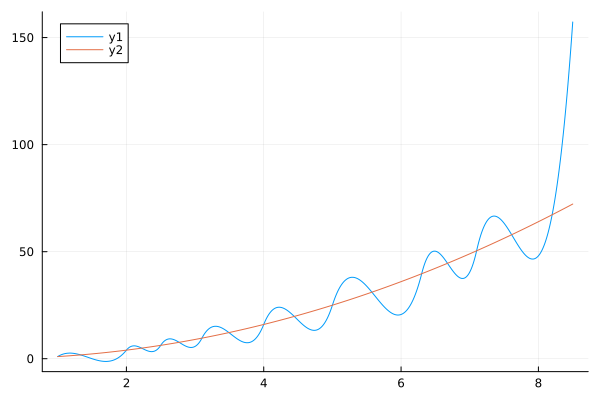

In [4]:
using DataInterpolations, Plots

ts = [1., 2., 2.5, 3.1, 4., 5.,6.3, 7.1, 8.2]
us = ts.^2;
dus = 20.0.*ts

itp = CubicHermiteSpline(dus,us,ts,extrapolate=true)
xs = 1.0:0.01:8.5
q = plot(xs,itp.(xs))
plot!(q,xs,xs.^2)

In [2]:
function euler_backward_EGM!(solution::AiyagariSolution,
                       economy::Economy)#::Nothing
    
    @unpack β,Tt,u,u′,inv_u′,ψ,inv_ψ′,a_size,aGrid,y_size,ys,Πy,iu,ie = economy
    @unpack ga,gc,gf,R,w,Us = solution
    gc_a = inverse_c_EGM(solution, economy)
    
    # gc is c(a) (because of update_cEGM!)
    # we need to invert Us
    u′s_next = similar(gc_a)
    u′s_next .= u′.(gc_a)
    
    Eu′s = similar(gc)
    for ia in eachindex(aGrid)
        for iy in eachindex(ys)
            Eu′s[ia,iy] = β*R*sum(u′s_next[ia,:].*Πy(gf[ia,iu])[iy,:])
        end
    end
    
    #@show size(u′s_next[ia,:].*Πy(gf[ia,iy])[iy,:]), size(u′s_next[ia,:]),size(Πy(gf[ia,iy])[iy,:])
    #@show u′s_next
    #return u′s_next,Πy(0.05),Eu′s/(β*R)
    #@show size(Eu′s), size(β*R*u′s_next*Πy(0.05)')
    
    Us_a = similar(Us) # Us_a is Us(a) and not Us(a') (as Us is)
    for iy in eachindex(ys)
        #itr = CubicHermiteSpline(u′.(gc[:,iy]),Us[:,iy],ga[:,iy],extrapolate=true)
        #CubicHermiteSpline(du, u, t) - A third order Hermite interpolation, which matches the values 
        # and first (du) order derivatives in the data points exactly.
        itr = LinearInterpolation(Us[:,iy],ga[:,iy],extrapolate=true) #more robust
        for ia in eachindex(aGrid)            
            Us_a[ia,iy] = itr(aGrid[ia])
        end
    end
    
    EUs  = similar(gc)
    for ia in eachindex(aGrid)
        for iy in eachindex(ys)
            EUs[ia,iy] = sum(Us_a[ia,:].*Πy(gf[ia,iu])[iy,:])
        end
    end
    
    cs = similar(gc) 
    ls = ones(typeof(β),size(gc))
    as = similar(gc)
    fs = zeros(typeof(β),size(gc))
    
    cs .= inv_u′.(Eu′s) 
    # cs is c(a') (because of next-period beg-of-period = current period end-of-period)
    for ia in eachindex(aGrid)
        for iy in eachindex(ys)
            as[ia,iy] = (aGrid[ia] + cs[ia,iy] - Tt - w*(ys[iy]*ls[ia,iy]))/R
            # as is a(a')
        end
        fs[ia,iu] = inv_ψ′(β*(Us_a[ia,ie]-Us_a[ia,iu]))
        # fs is f(a') since Us_a is Us(a) in the next period
    end
    fs = myBound(fs,zero(typeof(β)), one(typeof(β)))
    for ia in eachindex(aGrid)
        for iy in eachindex(ys)
            Us[ia,iy] = u(cs[ia,iy]) - ψ(fs[ia,iy]) + β*EUs[ia,iy]
        end
    end
    
    # as is a(a')
    # cs is c(a')
    # ls is l(a')
    # Us is U(a')
    
    # updates policy function in solution
    solution.gc .= cs
    solution.ga .= as
    solution.gl .= ls
    solution.gf .= fs
    solution.Us .= Us
    return nothing
end;

1

## Computing policy functions <a id="solve-EGM"></a>[<font size=1>(back to policy functions)</font>](#pol-fun)

We finally iterate on policy functions until there is no more change in the savings policy function. It uses the function `euler_back_EGM!`. 

The function is invoked by:
> `policy_fun_EGM!(solution, economy; tol::Float64=1e-6, maxiter::Int64=10000)`, 

where:
* `solution::AiyagariSolution` is a mutable `struct` `AiyagariSolution` where all policy functions are functions of end-of-period savings;
* `economy::Economy` is a immutable `struct` `Economy` which contains economy parameters;
* `tol::Float64` is a precision criterion to stop the convergence process;
* `maxiter::Int64` is a number of maximal repetitions (in case of non-convergence of policy function). 

The function stops when:
* either the relative difference between the policy function `ga` and its update is below the threshold `tol` (more formally if $g_a$ is the updated policy function and $\tilde g_a$ the former one, the criterion is $|g_{a,i_a,i_y} - \tilde g_{a,i_a,i_y}|/(g_{a,i_a,i_y} + \tilde g_{a,i_a,i_y}) < \varepsilon_{tol}$ for all $i_a,i_y$);
* or the number of iterations is above the number of repetitions `maxiter`.
The output message is different in both cases.

In [3]:
function policy_fun_EGM!(solution::AiyagariSolution,
                    economy::Economy;
                    tol::T=1e-8, maxiter::I=1000,print_step::I=100,
                    noprint::Bool=false)::Nothing where {T<:Real,I<:Integer}
    # ierates on policy functions until convergence
        
    as  = similar(solution.ga)
    as .= solution.ga
    fs  = similar(solution.gf)
    fs .= solution.gf
    i = 0
    while true 
        i += 1
        euler_backward_EGM!(solution, economy) #updates policy functions once
        test = max(maximum(abs.(solution.ga .- as) ./ (
                abs.(solution.ga) .+ abs.(as))), maximum(abs.(solution.gf .- fs)))
            
            #computation of the convergence criterion
        if test < tol
            # convergence is reached
            (!noprint)&&println("Solved in ",i," ","iterations")
            break
        end
        if i > maxiter
            # maximal nb of iterations is reached (but no convergence)
            println("Convergence not reached after ",i,"iterations. Criterion = ", test)
            break
        end
        if (!noprint)&&(i%print_step == 0) 
            println("iteration: ", i , " ", maximum(test))
            println("fs - gf: ", maximum(solution.gf.-fs))
            flush(stdout)
        end
        as .= solution.ga
        fs .= solution.gf
    end
    #println("fs - gf: ", maximum(abs.(solution.gf .- fs)) )
    return nothing
end;

# Computing stationary distribution <a id="stat-dist"></a>[<font size=1>(back to menu)</font>](#Aiyagari)

The stationary distribution is computed as the normalized eigenvector associated to the largest eigenvalue of the transition matrix. The computation thus involves two steps:
1. the [transition matrix](#transition-mat),
2. the [stationary distribution](#stat-dist-2) as an eigenvector.

## The transition matrix <a id="transition-mat"></a>[<font size=1>(back to stationary distribution menu)</font>](#stat-dist)

We compute the transition matrix $T$ over the product grid of savings and productivity.  The transition matrix is thus of size $n_an_y\times n_an_y$. Each element of the matrix corresponds to the probability to switch from one position in the product grid (characterized by one position in the asset grid and another position on the productivity grid) to another position on the product grid (hence another positions on the asset and productivity grids). 

### The non-EGM case

The standard (non-EGM) way to compute the transition matrix can be summarized as follows. We take as given from a starting position on the product grid characterized by indices $i_a$ and $i_y$ (for savings and productivity, respectively), as well as an arrival index $j_y$ on the productivity grid. The arrival index $j_a$ on the asset grid is endogenous and computed with the savings policy function using the current productivity level $\mathcal Y_{i_y}$ and beginning-of-period savings $a_{\text{Grid},i_a}$ (further precision below). Then, the transition probability between $(i_a,i_y)$ and $(j_a,j_y)$ is  given by the transition probability between productivity indices $i_y$ and $j_y$, $\Pi^y_{i_y,j_y}$, using the productivity transition matrix $\Pi^y$. 

#### How does ones *exactly* compute the endogenous index $j_a$ for the asset grid?

The savings policy function gives the end-of-period savings $a^\prime = g_{a,i_y,i_a}$ as a function on current productivity level $ \mathcal Y_{i_y}$ and beginning-of-period savings $a_{\text{Grid},i_a}$. However, there is no reason for $a^\prime$ to be exactly one of the points of the asset grids and $a^\prime$ actually lies between two grid points: there is $j_a$, such that $a_{\text{Grid},j_a}\le a^\prime< a_{\text{Grid},j_a+1}$. More precisely, we have to handle corner cases and such a $j_a$ does not exist if $a^\prime \ge a_{\text{Grid},n_a}$ or $a^\prime < a_{\text{Grid},1}$. Hence, we define $j_a = 1$ if $a^\prime < a_{\text{Grid},1}$ or $j_a=\min_j \{a^\prime \ge a_{\text{Grid},j}\}$ otherwise.

This means that the transition is actually from $(i_a,i_y)$ to  $(j_a,j_y)$ or $(j_a+1,j_y)$. We will assume that the probability to switch to $j_a$ or $j_a+1$ is attributed thanks to a linear approximation. Observe that:
$$a^\prime = \underbrace{\frac{a_{\text{Grid},j_a+1}-a^\prime}{a_{\text{Grid},j_a+1}-a_{\text{Grid},j_a}}}_{=p_a}a_{\text{Grid},j_a} + \underbrace{\frac{a^\prime-a_{\text{Grid},j_a}}{a_{\text{Grid},j_a+1}-a_{\text{Grid},j_a}}}_{=1-p_{a}}a_{\text{Grid},j_a+1},$$
where $p_{a}$ and $1-p_{a}$ can be interpreted as probabilities since $0\le p_{a}\le1$. Put it otherwise, we make the assumption that $a^\prime$ is the barycentre of $x_a$ and $x_{a+1}$ with repsective weights $a_{\text{Grid},j_a+1} -a^\prime$ and $a^\prime - a_{\text{Grid},j_a}$.

The transition probability from $(i_a,i_y)$ to  $(j_a,j_y)$ is thus $\Pi^y_{i_yj_y}$, the probability to switch from $i_y$ to $j_y$, times $p_a=\frac{a_{\text{Grid},j_a+1}-a^\prime}{a_{\text{Grid},j_a+1}-a_{\text{Grid},j_a}}$ the probability to switch from $a^\prime$ to $a_{i_a}$. Simiarly, the transition probability from $(i_a,i_y)$ to  $(j_a+1,j_y)$ is thus $\Pi^y_{i_yj_y}\times p_{a+1}$. 


#### Summary

Let take as given indices $(i_a,i_y)$ and $j_y$ and define $a^\prime = g_{a,i_y,i_a}$. If it exists, let $j_a$ be such that $a_{\text{Grid},j_a}\le a^\prime< a_{\text{Grid},j_a+1}$. Otherwise, if $a^\prime< a_{\text{Grid},1}$, let $j_a=1$ or if $a^\prime \ge a_{\text{Grid},n_a}$, let $j_a=n_a-1$. Defining
$$p_a = \max(\min(\frac{a_{\text{Grid},j_a+1}-a^\prime}{a_{\text{Grid},j_a+1}-a_{\text{Grid},j_a}},1),0),$$
we have:
\begin{align}
\Pi_{(i_a,i_y),(j_a,j_y)} &= p_a\Pi^y_{i_yj_y}, \\
\Pi_{(i_a,i_y),(j_a+1,j_y)} &= (1-p_a)\Pi^y_{i_yj_y}, \\
\forall j \notin\{j_a,j_a+1\}, \Pi_{(i_a,i_y),(j,j_y)}&= 0. \\
\end{align}

Note that the bounds for $p_a$ come from the corner cases for $j_a$. 

### The EGM case

This needs to be slightly adapted for EGM since the savings policy function characterizes beginning-of-period savings as a function of end-of-period savings. The idea is actually to include in the function the inversion of the policy function. Again we start from indices $(i_a,i_y)$ and $j_y$. Because of EGM, we use linear interporlation to obtain end-of-period savings: $a^\prime=lin(a_\text{Grid,i_a},g_{a,i_y},a_\text{Grid})$ and the fact that the interpolation is performed between indices $j_a$ and $j_a+1$. The implementation is then exactly as in the no-EGM case, except that it uses this trick:
$$\frac{a_{\text{Grid},j_a+1}-a^\prime}{a_{\text{Grid},j_a+1}-a_{\text{Grid},j_a}}=\frac{g_{i_y,j_a+1}-a_\text{Grid,i_a}}{g_{i_y,j_a+1}-g_{i_y,j_a}},$$
which directly comes from the linear interpolation (hence the function that maps  $[g_{i_y,j_a},g_{i_y,j_a+1}]$ onto $[a_{\text{Grid},j_a},a_{\text{Grid},j_a+1}]$ is affine) and the fact that the interpolation index $j_a$ is the same for the x-grid (here, $g_{a,i_y}$) and the y-grid (here, $a_\text{Grid}$). Observe that with the previous trick, the linear interpolation is actually only useful to compute the index $j_a$, while the quantity $a^\prime$ is useless. 

#### The implementation


There are two implementations, corresponding to the no-EGM and EGM cases. 

The no-EGM function is invoked by 

> `transitionMat(ga::Matrix{T},economy::Economy)::SparseMatrixCSC{T,I}`, 

where:
* `ga::Matrix{T}` is the saving policy function (a `a_size`$\times$ `y_size` matrix defined on the product grid of assets $\times$ productivity);

* `economy::Economy` is the economy.

The function returns a sparse matrix (of type `SparseMatrixCSC{T,I}` from the package `SparseArrays`) such that:
* the sparse matrix is of size `a_size⋅y_size`$\times$`a_size⋅y_size`;
* a matrix element corresponds to the probability to switch from a pair of (savings, productivity level) to another pair of (savings, productivity level).

The EGM function is invoked by 

> `transitionMat_EGM(ga::Matrix{T},economy::Economy)::SparseMatrixCSC{T,I}`, 

with the same specification as before.

***Remark.*** In the no-EGM case, the policy funtion `ga` should express end-of-period savings as a function of beginning-of-period savings. In the EGM case, the policy funtion `ga` should express beginning-of-period savings as a function of end-of-period savings.



In [4]:
# no-EGM case: a′ = ga(a)
function transitionMat(ga::Matrix{T}, gf::Matrix{T}, economy::Economy{T,I,T1,T2,T3,T4,T5,T6,T7,T8})::SparseMatrixCSC{T,I} where {
                            T<:Real,I<:Int64,T1<:Function,T2<:Function,T3<:Function,T4<:Function,
                                             T5<:Function,T6<:Function,T7<:Function,T8<:Function}
    @unpack a_size,a_min,aGrid,y_size,Πy,ys,iu = economy
    
    trans  = spzeros(T, I, a_size*y_size, a_size*y_size)
    p      = zero(T)
    i_mat  = zero(I)
    j_mat  = zero(I)
    πy     = zero(T)
    for ia in eachindex(aGrid)
        for iy in eachindex(ys)
            ja = searchsortedlast(aGrid, ga[ia,iy]) 
            #ia is the largest index such that aGrid[ia]≤x (and hence xs[ia+1]>x). Returns 0 if x≤xs[1]. xs sorted.

            #Adjust ia if x falls out of bounds of xs
            if ja == 0
                ja += 1
            elseif (ja==a_size)
                ja -= 1
            end  
            p = (ga[ia,iy]-aGrid[ja])/(aGrid[ja+1] - aGrid[ja])
            p = min(max(p,zero(T)),one(T))
            i_mat = (iy-1)*a_size
            for jy in eachindex(ys)
                j_mat = (jy-1)*a_size
                πy    = Πy(gf[ia,iu])[iy,jy]
                trans[i_mat+ia,j_mat+ja+1] += p * πy
                trans[i_mat+ia,j_mat+ja]   += (one(T)-p) * πy
            end
        end
    end   
    return trans
end;

In [5]:
# EGM case: a = ga(a′)
function transitionMat_EGM(ga::Matrix{T}, gf::Matrix{T}, economy::Economy{T,I,T1,T2,T3})::SparseMatrixCSC{T,I} where {
                            T<:Real,I<:Int64,T1<:Function,T2<:Function,T3<:Function}
    @unpack a_size,a_min,aGrid,y_size,Πy,ys,iu = economy
    
    trans  = spzeros(T, I, a_size*y_size, a_size*y_size)
    p      = zero(T)
    a′     = zero(T)
    ja     = zero(I)
    i_mat  = zero(I)
    j_mat  = zero(I)
    πy     = zero(T)
    for ia in eachindex(aGrid)
        for iy in eachindex(ys)
            a′, ja = interpLinear(aGrid[ia], ga[:,iy], aGrid, a_size, a_min)
            p = (aGrid[ia] - ga[ja,iy])/(
                    ga[ja+1,iy] - ga[ja,iy])
            p = min(max(p,zero(T)),one(T))
            i_mat = (iy-1)*a_size
            for jy in eachindex(ys)
                j_mat = (jy-1)*a_size
                πy    = Πy(gf[ia,iu])[iy,jy]
                trans[i_mat+ia,j_mat+ja+1] = p * πy
                trans[i_mat+ia,j_mat+ja] = (one(T)-p) * πy
            end
        end
    end   
    return trans
end;

## The stationary distribution <a id="stat-dist-2"></a>[<font size=1>(back to stationary distribution menu)</font>](#stat-dist)

We compute the stationary distribution using the [transition matrix](#transition-mat) discussed above. The stationary distribution $\pi_T$ of the transition matrix $T$ is the (row) vector of size $1\times n_a\cdot n_y$ that verifies:  $\forall i,\ \pi_{T,i} \ge  0$, $\sum_i \pi_{T,i} = 1$, and $\pi_T\cdot T = \pi_T$. In other words, $\pi_T$ is teh normalized eigenvector associated to the matrix $T^\top$. If the matrix $T$ is irreducible and aperiodic, $\pi_T$ exist and is unique. If $\lim_{k\rightarrow \infty} T^k$ exists, then $\lim_{k\rightarrow \infty} T^k = \mathbf{1}\pi_T$.

In practice, we rely on the function `powm!` of the package `IterativeSolvers`. This function computes the largest eigenvalue (in absolute value) and the related  eigenvector of a matrix.

The function actually computing the stationary distribution is invoked with: 
> `stationaryDist(M; tol::Float64=1e-16, maxiter::Int64=100000)`, 

where:
* `M::SparseMatrixCSC{T,I}` is a (sparse) transition matrix that results from function `transitionMat`;
* `tol::Float64 = 1e-6` is a precision criterion to stop the convergence process;
* `maxiter::Int64=10000` is a number of maximal repetitions (in case of non-convergence of the computation).

 The function returns a vector $\Pi$ of size `a_size⋅y_size` that verifies $\Pi M=\Pi$ and is  stationary distribution -- that is known to exist. It is computed as the normalised eigenvector corresponding to the largest eigen value of the transition matrix -- which is $1$. 

In [6]:
function stationaryDist(M::SparseMatrixCSC{T,I}; tol::T=1e-16, maxiter::I=1000000
        )::Vector{T} where {T<:Real,I<:Integer}
    nM = size(M)[2]
    _, x = powm!(Matrix(M'), ones(T, nM), 
                    maxiter = maxiter,tol = tol)
    # returns the approximate largest eigenvalue λ of M and one of its eigenvector
    # we need to transpose M (see above)
    norm(x'*M - x') > nM*tol && println(norm(x'*M - x'))
    return x/sum(x)
end
function stationaryDist(M::AbstractMatrix{T}; tol::T=1e-16, maxiter::I=100000
        )::Vector{T} where {T<:Real,I<:Integer}
    nM = size(M)[2]
    _, x = powm!(M', ones(T, nM), 
                    maxiter = maxiter,tol = tol)
    # returns the approximate largest eigenvalue λ of M and one of its eigenvector
    # we need to transpose M (see above)
    @assert norm(x'*M - x') < nM*tol
    return x/sum(x)
end;

# The steady-state equilibrium  <a id="steady-state"></a>[<font size=1>(back to menu)</font>](#Aiyagari)

There are three functions:
* the [computation](#computation-steady-state) of the steady-state equilibrium;
* the [verification](#consistency-steady-state) that the previous solution is consistent;
* the [description](#description-steady-state) of the model solution.

## Computation of the steady-state equilibrium <a id="computation-steady-state"></a>[<font size=1>(back to menu)</font>](#steady-state)

The function: 
> `steady(economy; tol::T=1e-8, maxiter::I=100000)` 

computes the steady-state solution of the Aiyigary model, where (as before):
* `economy::Economy` is a immutable `struct` `Economy` which contains economy parameters;
* `tol::T=1e-8` is a precision criterion to stop the convergence process;
* `maxiter::I=100000` is a number of maximal repetitions (in case of non-convergence of computations). 

The function returns the steady-state allocation under the form of a mutable `struct` of type `AiyagariSolution{T,I}`. 

The function `steady`relies on previous functions, in particular `SolveEGM!` for computing steady-state policy functions and `stationaryDist` to compute the stationnary distribution.

In [7]:
function steady(economy::Economy;print_step::I=50,
                tolEGM::T=1e-8, maxiterEGM::I=100000, 
                tolSD::T=1e-16, maxiterSD::I=500000,
                noprint::Bool=false)::AiyagariSolution{T,I} where {T<:Real,I<:Integer}

    @unpack β,Tt,u′,a_size,a_min,a_max,aGrid,y_size,ys,iu = economy
    solution = AiyagariSolution(economy)
    
    # computing steady-state policy function
    policy_fun_EGM!(solution, economy, tol=tolEGM, maxiter=maxiterEGM, print_step=print_step,noprint=noprint)
    
    @unpack ga,gf,gf,R,w = solution
    
    resE = similar(ga)
    as = similar(ga)  #policy rules as a function of beginning of period savings
    ls = ones(typeof(β),size(ga))  #policy rules as a function of beginning of period savings
    cs = similar(ga)  #policy rules as a function of beginning of period savings
    fs = similar(gf)

    # we 'invert' policy functions (to obtain policy rules as  a function of beginning of period savings)
    err = zero(T)
    for ia in eachindex(aGrid)
        for iy in eachindex(ys)
            as[ia,iy] = interpLinear(aGrid[ia], ga[:,iy], aGrid, a_size, a_min)[1]
            cs[ia,iy] = R*aGrid[ia] - as[ia,iy] + w*ys[iy] + Tt
            fs[ia,iy] = interpLinear(aGrid[ia], ga[:,iy], gf[:,iy], a_size, 0.)[1]
        end
    end
    solution.ga = as
    solution.gc = cs
    solution.gl = ls
    solution.gf = fs
    
    # computing stationnary distribution
    if norm(transitionMat_EGM(ga,fs,economy) .- transitionMat(as,fs,economy))>1e-12
        @show norm(transitionMat_EGM(ga,fs,economy) .- transitionMat(as,gf,economy))
    end
    solution.transitMat = transitionMat(as,fs,economy)
    solution.stationaryDist = reshape(stationaryDist(solution.transitMat,tol=tolSD,maxiter=maxiterSD), 
        a_size, y_size)
    
    # We compute aggregate quantities
    solution.A = sum(solution.stationaryDist.*as) #aggregate savings
    solution.C = sum(solution.stationaryDist.*cs) #aggregate consumption
    solution.L = sum(solution.stationaryDist.*(repeat(ys,1,a_size)'.*ls)) #aggregate labor supply
    solution.F = sum(solution.stationaryDist[:,iu].*fs[:,iu])/sum(solution.stationaryDist[:,iu]) #aggregate labor supply
    
    # We check Euler equations by computing their residuals
    solution.residEuler = u′.(cs) - β*R*reshape(
        solution.transitMat*reshape(u′.(cs),a_size*y_size,1),a_size,y_size)

    return solution
end;

## Checking the consistency of the solution  <a id="consistency-steady-state"></a>[<font size=1>(back to menu)</font>](#steady-state)


The function: 
> check_solution(solution::AiyagariSolution, economy::Economy; noprint::Bool=false)::Nothing

verifies that the solution of the Aiyagari model is internally consistent. The function returns `nothing` but raises a warning `@warn` when an inconsistency is found. Function's arguments are:
* the Aiyagari solution `solution` of type `AiyagariSolution`,
* the economy parameters `economy` of type `Economy`,
* the optional Boolean `noprint` stating if positive outcomes should not be printed (`true`if no print) -- `warning` always apppear.

The elements that are tested are the following ones (in this order):
* the stationary distribution sums to 1;
* the aggregate labor supply is consistent with labor policy functions;
* capital is consistent with modified golden rule and aggregate labor supply;
* aggregate savings are consistent with end-of-period savings (saving policy function);
* aggregate savings are consistent with beginning-of-period savings (asset grid);
* aggregate consumption is consistent with aggregate individual budget constraints;
* government budget constraint holds;
* economy resource constraint holds;
* governemnt budget constraint holds (once consumption tax is accounted for).

In [8]:
function check_solution(solution::AiyagariSolution, economy::Economy; noprint::Bool=false)::Bool
    @unpack β,Tt,a_size,a_min,aGrid,y_size,ys = economy
    @unpack ga,gc,gl,R,w,A,C,L,stationaryDist = solution
    if !(sum(stationaryDist) ≈ 1.0)
        @warn("error in stationary distribution. Sum: ", round(sum(stationaryDist),digits=4))
        return false
    else
        (!noprint)&&println("Passed: stationary distribution. Sum: ", round(sum(stationaryDist),digits=4))
    end
    if !(sum(stationaryDist .* ((repeat(ys,1,a_size)' .* gl))) ≈ L)
        @warn("error in aggregate labor supply. L=", round(L,digits=4), 
            "; ∫lᵢℓ(di)=", round(sum(stationaryDist .* ((repeat(ys,1,a_size)' .* gl))),digits=4))
        return false
    else
        (!noprint)&&println("Passed: aggregate labor supply. L=", round(L,digits=4), 
            "; ∫lᵢℓ(di)=", round(sum(stationaryDist .* ((repeat(ys,1,a_size)' .* gl))),digits=4))
    end
    if !(A ≈ sum(stationaryDist.*ga))
        @warn("Diff in aggregate savings. A-∫aᵢℓ(di)=",A-sum(stationaryDist.*ga))
        return false
    else
        (!noprint)&&println("Passed: aggregate savings. A=",round(A,digits=4), 
            "; ∫aᵢ′ℓ(di)=",round(sum(stationaryDist.*ga),digits=4))
    end
    if abs(A-sum(stationaryDist.*repeat(economy.aGrid,1,y_size))) > 1e-2
        @warn("error in convergence for savings. A-∫aᵢℓ(di)=",
            A-sum(stationaryDist.*repeat(economy.aGrid,1,y_size)))
        return false
    else
        (!noprint)&&println("Passed: convergence for savings. A=",round(A,digits=4), 
            "; ∫aᵢℓ(di)=",round(sum(stationaryDist.*repeat(economy.aGrid,1,y_size)),digits=4))
    end

    return true
end

## Describing the model solution <a id="description-steady-state"></a></a>[<font size=1>(back to menu)</font>](#steady-state)

The following function computes a number of useful quantities (Gini, public-spending-to-GDP, etc.) characterizing the steady state. The function is invoked by: 
> `describe_solution(solution::AiyagariSolution, economy::Economy; calib::String="quarterly")`, 

where:
* `solution::AiyagariSolution` is the mutable `struct` containing the steady-state allocation;
* `economy::Economy` is a immutable `struct` `Economy` which contains economy parameters;
* `calib::String="quarterly"` is a parameter used to adjust GDP to obtain standard debt- and public spending-to-GDP values. The function solely handles quarterly (if a 'q' in `calib`) or annual (otherwise) frequency.

The function returns the description as a dictionary of type `Dict{String,T}`. The dictionary can be printed with  `print_dict` from [Utils](./Utils.ipynb).

In [9]:
function describe_solution(solution::AiyagariSolution, economy::Economy; calib::String="quarterly")    
    @unpack β,Tt,u′,a_size,a_min,aGrid,y_size,ys = economy
    @unpack ga,gc,gl,R,w,A,C,L,stationaryDist,residEuler = solution
    T = typeof(β)
    
    # Adjusting stocks to the calibration (quarterly or yearly)
    stock_adj = occursin('q', lowercase(calib)) ? 4one(typeof(β)) : one(typeof(β))
        
    # Computing MPC
    diff_gc = gc[2:end,:] - gc[1:end-1,:]
    diff_ga = aGrid[2:end,:] - aGrid[1:end-1,:]
    mpc = sum(diff_gc.*stationaryDist[1:end-1,:]./diff_ga)
    
    
    return Dict{String,T}("01. Gini" => Gini(ga, stationaryDist), 
                "08. Aggregate labor supply, L" => L,
                "09. Average MPC" => mpc,
                "14. Share of credit-constrained agents" => sum(stationaryDist[1,:]))
end